## Predicting online enrollment percentage using Random Forest,XGBoost and LightGBM Regressor

### Created in Nov 21, 2025
### Purpose: Using online enrollment percentage of 2012-2022 to predict 2023 online enrollment percentage (panel data)

In [43]:
!source .venv/bin/activate
!pip install seaborn scikit-learn xgboost FixedEffectModel tslearn

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor  # or other ML model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# (optional) For panel-data / fixed-effect modeling
from fixedeffect.fe import fixedeffect  # from package FixedEffectModel  OR
# or: import linearmodels (or pydynpd) for dynamic panel data modeling if desired

from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans



In [4]:
# cluster = pd.read_csv('data_with_inst_clusters1027.csv')

data = pd.read_csv('initial_analyze1027.csv')

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/4229756228.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('initial_analyze1027.csv')


In [5]:
data = data.sort_values(['unitid', 'year'])
data = data.set_index(['unitid', 'year'])


In [6]:
data.columns

Index(['instnm', 'addr', 'city', 'stabbr', 'zip', 'fips', 'obereg', 'chfnm',
       'chftitle', 'gentele',
       ...
       'parent_merge', 'child_binary', 'n_unitid_year', 'shared_opeid_year',
       'erll_dist_perc', 'missing', 'close', 'pcert', 'pcertde',
       'hdegofr1_cat'],
      dtype='object', length=697)

In [7]:
# create lagged features
data['lag1_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(1)
data['lag2_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(2)
data['lag3_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(3)

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/2475385225.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag1_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(1)
/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/2475385225.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag2_erll_perc'] = data.groupby(level=0)['erll_dist_perc'].shift(2)
/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/2475385225.py:4: PerformanceWarning: DataFrame is highly fragment

In [8]:
# drop rows with missing values due to lagging
data = data.dropna(subset=['lag1_erll_perc'])

### Select features for prediction

### categorical features

### static, barely change with time
- fips: state
- hbcu: HBCU indicator
- tribal: tribal indicator
- locale: urbanicity
- instsize: size
- c21basic: carnegie classification 2021
- ccbasic : carnegie classification 2010



In [9]:
# make a new column urbanicity based on locale
# locale: 11,12,13 = City; 21,22,23 = Suburb; 31,32,33 = Town; 41,42,43 = Rural
# label define label_locale 11 "City: Large"
# label define label_locale 12 "City: Midsize",add
# label define label_locale 13 "City: Small",add
# label define label_locale 21 "Suburb: Large",add
# label define label_locale 22 "Suburb: Midsize",add
# label define label_locale 23 "Suburb: Small",add
# label define label_locale 31 "Town: Fringe",add
# label define label_locale 32 "Town: Distant",add
# label define label_locale 33 "Town: Remote",add
# label define label_locale 41 "Rural: Fringe",add
# label define label_locale 42 "Rural: Distant",add
# label define label_locale 43 "Rural: Remote",add
# label define label_locale -3 "{Not available}",add

# make locale below 0 is missing
data['locale'] = data['locale'].apply(lambda x: x if x > 0 else np.nan)
data['instsize'] = data['instsize'].apply(lambda x: np.nan if x < 0 else x)

data['urbanicity'] = data['locale'].apply(lambda x: 'City' if x in [11,12,13] else ('Suburb' if x in [21,22,23] else ('Town' if x in [31,32,33] else ('Rural' if x in [41,42,43] else np.nan))))

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/3063331624.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['urbanicity'] = data['locale'].apply(lambda x: 'City' if x in [11,12,13] else ('Suburb' if x in [21,22,23] else ('Town' if x in [31,32,33] else ('Rural' if x in [41,42,43] else np.nan))))


In [10]:
# instsize
# label define label_instsize 1 "Under 1,000"
# label define label_instsize 2 "1,000 - 4,999",add
# label define label_instsize 3 "5,000 - 9,999",add
# label define label_instsize 4 "10,000 - 19,999",add
# label define label_instsize 5 "20,000 and above",add
# label define label_instsize -1 "Not reported",add
# label define label_instsize -2 "Not applicable",add



In [11]:

# recode c21basic 
# label define label_c21basic 1 "Associate^s Colleges: High Transfer-High Traditional"
# label define label_c21basic 2 "Associate^s Colleges: High Transfer-Mixed Traditional/Nontraditional",add
# label define label_c21basic 3 "Associate^s Colleges: High Transfer-High Nontraditional",add
# label define label_c21basic 4 "Associate^s Colleges: Mixed Transfer/Career & Technical-High Traditional",add
# label define label_c21basic 5 "Associate^s Colleges: Mixed Transfer/Career & Technical-Mixed Traditional/Nontraditional",add
# label define label_c21basic 6 "Associate^s Colleges: Mixed Transfer/Career & Technical-High Nontraditional",add
# label define label_c21basic 7 "Associate^s Colleges: High Career & Technical-High Traditional",add
# label define label_c21basic 8 "Associate^s Colleges: High Career & Technical-Mixed Traditional/Nontraditional",add
# label define label_c21basic 9 "Associate^s Colleges: High Career & Technical-High Nontraditional",add
# label define label_c21basic 10 "Special Focus Two-Year: Health Professions",add
# label define label_c21basic 11 "Special Focus Two-Year: Technical Professions",add
# label define label_c21basic 12 "Special Focus Two-Year: Arts & Design",add
# label define label_c21basic 13 "Special Focus Two-Year: Other Fields",add
# label define label_c21basic 14 "Baccalaureate/Associate^s Colleges: Associate^s Dominant",add
# label define label_c21basic 15 "Doctoral Universities: Very High Research Activity",add
# label define label_c21basic 16 "Doctoral Universities: High Research Activity",add
# label define label_c21basic 17 "Doctoral/Professional Universities",add
# label define label_c21basic 18 "Master^s Colleges & Universities: Larger Programs",add
# label define label_c21basic 19 "Master^s Colleges & Universities: Medium Programs",add
# label define label_c21basic 20 "Master^s Colleges & Universities: Small Programs",add
# label define label_c21basic 21 "Baccalaureate Colleges: Arts & Sciences Focus",add
# label define label_c21basic 22 "Baccalaureate Colleges: Diverse Fields",add
# label define label_c21basic 23 "Baccalaureate/Associate^s Colleges: Mixed Baccalaureate/Associate^s",add
# label define label_c21basic 24 "Special Focus Four-Year: Faith-Related Institutions",add
# label define label_c21basic 25 "Special Focus Four-Year: Medical Schools & Centers",add
# label define label_c21basic 26 "Special Focus Four-Year: Other Health Professions Schools",add
# label define label_c21basic 27 "Special Focus Four-Year: Research Institutions",add
# label define label_c21basic 28 "Special Focus Four-Year: Engineering and Other Technology-Related Schools",add
# label define label_c21basic 29 "Special Focus Four-Year: Business & Management Schools",add
# label define label_c21basic 30 "Special Focus Four-Year: Arts, Music & Design Schools",add
# label define label_c21basic 31 "Special Focus Four-Year: Law Schools",add
# label define label_c21basic 32 "Special Focus Four-Year: Other Special Focus Institutions",add
# label define label_c21basic 33 "Tribal Colleges",add


# map carnegie types with c21basic
# c21basic 1-9 correspond to the carnegie 5
# c21basic 10-13 correspond to the carnegie 6
# c21basic 21 and 22 correspond to the carnegie 3
# c21basic 14 and 23 correspond to the carnegie 4
# c21basic 15-17 correspond to the carnegie 1
# c21basic 18-20 correspond to the carnegie 2
# c21basic 24-32 correspond to the carnegie 6
# c21basic 33 correspond to the carnegie 7

# label define label_harmonized 1 "Doctoral/Research Universities" ///
#                             2 "Master's Colleges & Universities" ///
#                             3 "Baccalaureate Colleges" ///
#                             4 "Baccalaureate/Associate's Colleges" ///
#                             5 "Associate's Colleges" ///
#                             6 "Special Focus Institutions" ///
#                             7 "Tribal Colleges" ///
#                             8 "Not applicable"

def map_carnegie(c21basic):
    if c21basic in range(1, 10):
        return 5
    elif c21basic in range(10, 14):
        return 6
    elif c21basic in [21, 22]:
        return 3
    elif c21basic == 14 or c21basic == 23:
        return 4
    elif c21basic in range(15, 18):
        return 1
    elif c21basic in range(18, 21):
        return 2
    elif c21basic in range(24, 33):
        return 6
    elif c21basic == 33:
        return 7
    else:
        return np.nan  
    
data['carnegie21'] = data['c21basic'].apply(map_carnegie)

data['carnegie21'].value_counts()



/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/4190505.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['carnegie21'] = data['c21basic'].apply(map_carnegie)


carnegie21
5.0    2482
2.0     706
1.0     685
4.0     387
3.0     247
6.0     101
7.0      87
Name: count, dtype: int64

In [12]:
# label define label_ccbasic 1 "Associate^s--Public Rural-serving Small"
# label define label_ccbasic 2 "Associate^s--Public Rural-serving Medium",add
# label define label_ccbasic 3 "Associate^s--Public Rural-serving Large",add
# label define label_ccbasic 4 "Associate^s--Public Suburban-serving Single Campus",add
# label define label_ccbasic 5 "Associate^s--Public Suburban-serving Multicampus",add
# label define label_ccbasic 6 "Associate^s--Public Urban-serving Single Campus",add
# label define label_ccbasic 7 "Associate^s--Public Urban-serving Multicampus",add
# label define label_ccbasic 8 "Associate^s--Public Special Use",add
# label define label_ccbasic 9 "Associate^s--Private Not-for-profit",add
# label define label_ccbasic 10 "Associate^s--Private For-profit",add
# label define label_ccbasic 11 "Associate^s--Public 2-year colleges under 4-year universities",add
# label define label_ccbasic 12 "Associate^s--Public 4-year Primarily Associate^s",add
# label define label_ccbasic 13 "Associate^s--Private Not-for-profit 4-year Primarily Associate^s",add
# label define label_ccbasic 14 "Associate^s--Private For-profit 4-year Primarily Associate^s",add
# label define label_ccbasic 15 "Research Universities (very high research activity)",add
# label define label_ccbasic 16 "Research Universities (high research activity)",add
# label define label_ccbasic 17 "Doctoral/Research Universities",add
# label define label_ccbasic 18 "Master^s Colleges and Universities (larger programs)",add
# label define label_ccbasic 19 "Master^s Colleges and Universities (medium programs)",add
# label define label_ccbasic 20 "Master^s Colleges and Universities (smaller programs)",add
# label define label_ccbasic 21 "Baccalaureate Colleges--Arts & Sciences",add
# label define label_ccbasic 22 "Baccalaureate Colleges--Diverse Fields",add
# label define label_ccbasic 23 "Baccalaureate/Associate^s Colleges",add
# label define label_ccbasic 24 "Theological seminaries, Bible colleges, and other faith-related institutions",add
# label define label_ccbasic 25 "Medical schools and medical centers",add
# label define label_ccbasic 26 "Other health professions schools",add
# label define label_ccbasic 27 "Schools of engineering",add
# label define label_ccbasic 28 "Other technology-related schools",add
# label define label_ccbasic 29 "Schools of business and management",add
# label define label_ccbasic 30 "Schools of art, music, and design",add
# label define label_ccbasic 31 "Schools of law",add
# label define label_ccbasic 32 "Other special-focus institutions",add
# label define label_ccbasic 33 "Tribal Colleges",add
# label define label_ccbasic -2 "Not applicable, not in Carnegie universe (not accredited or nondegree-granting)",add


def map_carnegie10(ccbasic):
    if ccbasic in range(1, 15):
        return 5
    elif ccbasic in range(15, 18):
        return 1
    elif ccbasic in range(18, 21):
        return 2
    elif ccbasic in range(21, 23):
        return 3
    elif ccbasic == 23:
        return 4
    elif ccbasic in range(24, 33):
        return 6
    elif ccbasic == 33:
        return 7
    else:
        return np.nan  
    
data['carnegie10'] = data['ccbasic'].apply(map_carnegie10)

data['carnegie10'].value_counts()

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/1206042238.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['carnegie10'] = data['ccbasic'].apply(map_carnegie10)


carnegie10
5.0    10409
2.0     2788
1.0     1935
3.0      980
7.0      278
4.0      264
6.0      233
Name: count, dtype: int64

#### Numerical variables

- erll_dist_perc: online enrollment percentage
- lag1_erll_perc: one year lag of online enrollment percentage
- lag2_erll_perc: two year lag of online enrollment percentage
- eftotlt3:  Undergraduate, degree/certificate-seeking student in total (Undergraduate: A student enrolled in a 4- or 5-year bachelor's degree program, an associate's degree program, or a vocational or technical program below the baccalaureate.  )

In [13]:
# only keep categorical variables and lagged features
data = data[['fips', 'hbcu','tribal', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10', 'eftotlt3','lag1_erll_perc', 'lag2_erll_perc', 'erll_dist_perc']]
rnn_data = data

In [14]:
# make 'fips', 'hbcu', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10' categorical variables
data['fips'] = data['fips'].astype('category')
data['hbcu'] = data['hbcu'].astype('category')
data['tribal'] = data['tribal'].astype('category')
data['urbanicity'] = data['urbanicity'].astype('category')
data['instsize'] = data['instsize'].astype('category')
data['carnegie21'] = data['carnegie21'].astype('category')
data['carnegie10'] = data['carnegie10'].astype('category')
# one-hot encoding for categorical variables will be done in modeling step
data =pd.get_dummies(data, columns=['fips', 'hbcu', 'tribal', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10'], drop_first=True)

In [15]:
data.columns

Index(['eftotlt3', 'lag1_erll_perc', 'lag2_erll_perc', 'erll_dist_perc',
       'fips_2', 'fips_4', 'fips_5', 'fips_6', 'fips_8', 'fips_9', 'fips_10',
       'fips_11', 'fips_12', 'fips_13', 'fips_15', 'fips_16', 'fips_17',
       'fips_18', 'fips_19', 'fips_20', 'fips_21', 'fips_22', 'fips_23',
       'fips_24', 'fips_25', 'fips_26', 'fips_27', 'fips_28', 'fips_29',
       'fips_30', 'fips_31', 'fips_32', 'fips_33', 'fips_34', 'fips_35',
       'fips_36', 'fips_37', 'fips_38', 'fips_39', 'fips_40', 'fips_41',
       'fips_42', 'fips_44', 'fips_45', 'fips_46', 'fips_47', 'fips_48',
       'fips_49', 'fips_50', 'fips_51', 'fips_53', 'fips_54', 'fips_55',
       'fips_56', 'fips_60', 'fips_64', 'fips_66', 'fips_68', 'fips_69',
       'fips_70', 'fips_72', 'fips_78', 'hbcu_2', 'tribal_2',
       'urbanicity_Rural', 'urbanicity_Suburb', 'urbanicity_Town',
       'instsize_2.0', 'instsize_3.0', 'instsize_4.0', 'instsize_5.0',
       'carnegie21_2.0', 'carnegie21_3.0', 'carnegie21_4.0', 'car

### Split into train/test respecting time ordering

In [16]:
train = data[data.index.get_level_values('year') <= 2022]
test = data[data.index.get_level_values('year') > 2022]
X_train = train.drop(columns=['erll_dist_perc'])
y_train = train['erll_dist_perc']
X_test = test.drop(columns=['erll_dist_perc'])
y_test = test['erll_dist_perc']

### XGBoost, Random Forest and LightGBM

In [17]:
# !pip install lightgbm

In [18]:

#  XGBoost
model_xgb = XGBRegressor(n_estimators=100, random_state=0)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost Test MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost Test MAE:", mean_absolute_error(y_test, y_pred_xgb))

# change the regressor to Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=0)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Random Forest Test MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest Test MAE:", mean_absolute_error(y_test, y_pred_rf))

# # change the regressor to LightGBM
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(n_estimators=100, random_state=0)
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_test)
print("LightGBM Test MSE:", mean_squared_error(y_test, y_pred_lgb))
print("LightGBM Test MAE:", mean_absolute_error(y_test, y_pred_lgb))



XGBoost Test MSE: 81.87119696370917
XGBoost Test MAE: 5.851851200887533
Random Forest Test MSE: 82.2599792279563
Random Forest Test MAE: 6.068862986352584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 15597, number of used features: 75
[LightGBM] [Info] Start training from score 17.131061
LightGBM Test MSE: 58.79298643140926
LightGBM Test MAE: 5.147296995246796


### Interpretation

- XGBoost: Test MSE: ~ 81.9, Test MAE: ~ 5.9
- Random Forest: Test MSE: ~ 82.3, Test MAE: ~ 6.1
- LightGBM: Test MSE: ~ 58.8, Test MAE: ~ 5.1

- LightGBM: On average, the prediction is about 5.1 percentage points off from the true value. Typical predictions (in squared-error sense) are off by ~8 points. LightGBM is doing the best job at predicting the outcome in terms of both average error and penalizing large errors.

- Heterogeneity across institutions: Given the  panel data (1000+ institutions, short panel), a global model like LightGBM may do well overall, but might perform poorly for some sub-types of institutions.

- The test set likely reflects similar conditions to training; if in future years institutions behave differently (policy changes, shocks, nonstationarity), performance may degrade. ML models trained on past patterns can fail when the underlying data-generation process changes


In [19]:
# check R squred of all models
from sklearn.metrics import r2_score
# r2_lgb = r2_score(y_test, y_pred_lgb)
# print("LightGBM Test R-squared:", r2_lgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost Test R-squared:", r2_xgb)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Test R-squared:", r2_rf)

XGBoost Test R-squared: 0.7560732101387175
Random Forest Test R-squared: 0.7549148734685593


- Roughly 82% of the variation in the outcome is being explained by the model. The model captures a fairly large share of the variation — which is quite substantial, especially in institutional data settings.

- R^2 has limitations. With panel / time-series data, high R^2 might come from “persistence” rather than meaningful predictive structure — if your outcome tends to move slowly over time (high autocorrelation), a model that mostly predicts “same as last year / small change” may get high 
R^2 but still do poorly at detecting real shifts or regime change. Scholars caution aboutover-interpreting R^2 in time-series / trending data

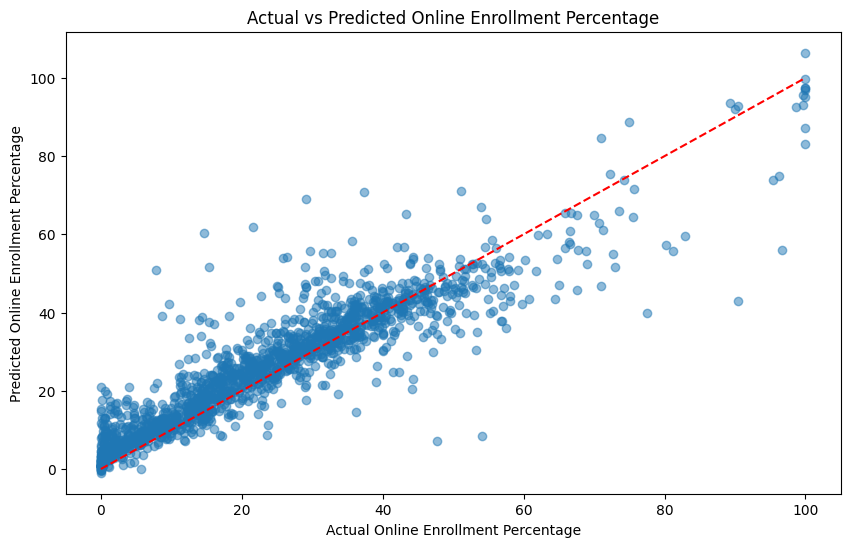

In [20]:
# residual plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Online Enrollment Percentage')
plt.ylabel('Predicted Online Enrollment Percentage')
plt.title('Actual vs Predicted Online Enrollment Percentage')
plt.show()

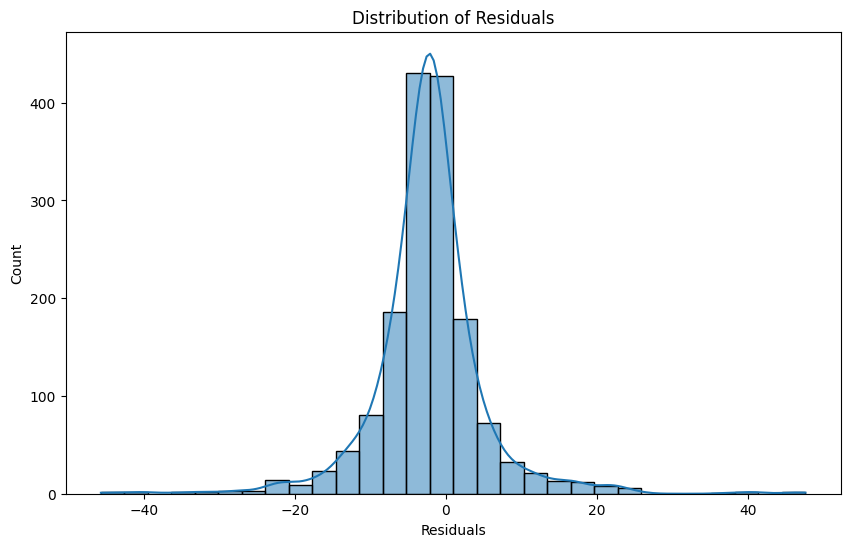

In [21]:
# residual analysis
residuals = y_test - y_pred_lgb
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

- The model is not consistently over-predicting or under-predicting across the board, but there are some fairly large residuals in the tails

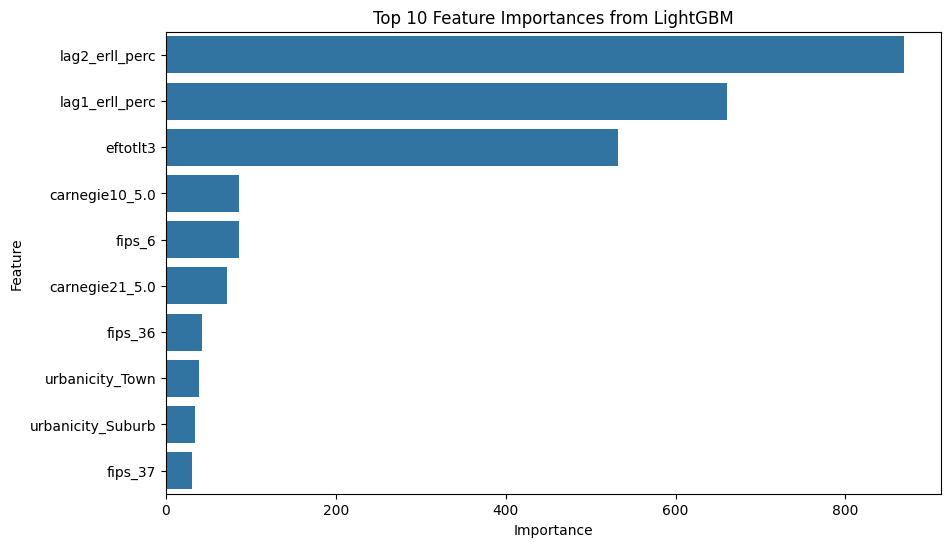

In [22]:
# feature importance of LightGBM
importances = model_lgb.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# visualize feature importance of the top 10 features 
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances from LightGBM')
plt.show()


- The outcome appears to be highly autocorrelated (or “persistent”) over time: knowing last two years' value gives a lot of information about the next-year value. The data behaves like an autoregressive process: past values are powerful predictors of future value

In [23]:
# diagnostic of institutions with residuals > 20
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lgb, 'Residual': residuals})
residuals_df = residuals_df[residuals_df['Residual'].abs() > 10]
residuals_df = residuals_df.sort_values(by='Residual', key=abs, ascending=False)
residuals_df.shape

(200, 3)

In [24]:
# export residuals_df
residuals_df.to_csv('residuals_diagnostic.csv')

### Residuals Diagnostic

- There are 200 institutions with residuals above 10%. They can be identified as institutions with unpredictable changes in online enrollment in 2023. 
- There can also be data reporting issues that make the prediction not accurate.

In [25]:
df = pd.read_csv('initial_analyze1027.csv')
# merge with residuals_df to get institution info
diagnostic_df = residuals_df.merge(df, left_index=True, right_on=['unitid', 'year'], how='left')


/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/981130322.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('initial_analyze1027.csv')


In [26]:
diagnostic_df['stabbr'].value_counts() # CA, TX, NC and NY

stabbr
CA    71
TX    12
NC    12
NY    11
NM     9
OH     9
NJ     7
OK     6
MA     6
FL     5
WA     4
WI     4
IL     3
PA     3
MN     3
MI     3
AR     3
SC     3
OR     2
LA     2
KS     2
NH     2
VA     2
ND     2
AZ     2
NE     2
TN     1
SD     1
MT     1
PR     1
WV     1
VT     1
MD     1
MP     1
IN     1
ME     1
Name: count, dtype: int64

In [27]:
diagnostic_df['iclevel'].value_counts() # most of them are at lease 2 but less than 4 year institutions

iclevel
2    129
1     71
Name: count, dtype: int64

### 
- Assiciate's colleges (1-9) are having unpredictable changes in online enrollment in 2023.
- 129 out of 200 institutions are associate's colleges with unpredictable changes (> 10%) in online enrollment in 2023.
- CA, TX, NC, NY has 106 institutions with unpredictable changes, which may reflect on their state policy changes.

In [28]:
diagnostic_df['c21basic'].value_counts() # most of them are associate's colleges


c21basic
1.0     27
2.0     19
6.0     19
3.0     18
4.0     17
15.0    17
33.0    14
14.0    14
8.0      8
5.0      8
18.0     7
9.0      7
7.0      6
23.0     4
16.0     4
20.0     3
19.0     2
22.0     2
29.0     1
21.0     1
27.0     1
17.0     1
Name: count, dtype: int64

## RNN prediction

In [29]:
rnn_data = rnn_data.reset_index()

In [30]:
finance_data = pd.read_csv("./financial_analyze1201.csv")

expend_list = ['f1c011',  'f1c021', 'f1c031', 'f1c051', 'f1c061', 'f1c071', 'f1c101', 'f1c141']
revenue_list = ["f1b01","f1b02","f1b03","f1b04a","f1b04b","f1b08","f1b10","f1b11","f1b12","f1b13","f1b14","f1b15","f1b16","f1b17","f1b18","f1b24"]

finance_data = finance_data[['unitid', 'year'] + expend_list + revenue_list]
finance_data['total_revenue'] = finance_data[revenue_list].sum(axis=1)
finance_data['total_expend'] = finance_data[expend_list].sum(axis=1)
finnace_data_cleaned = finance_data[['unitid', 'year', 'total_revenue', 'total_expend']]
rnn_data_cleaned = rnn_data.merge(finnace_data_cleaned, on=['unitid', 'year'], how='left')
rnn_data_cleaned = rnn_data_cleaned[['unitid', 'year','hbcu', 'tribal', 'urbanicity', 'instsize', 'carnegie10', 'eftotlt3', 'erll_dist_perc', 'total_revenue', 'total_expend']]
rnn_data_cleaned.head()



,unitid,year,hbcu,tribal,urbanicity,instsize,carnegie10,eftotlt3,erll_dist_perc,total_revenue,total_expend
0,100654,2013,1,2,City,3.0,2.0,4051,0.000000,122333536.0,131898901.0
1,100654,2014,1,2,City,3.0,2.0,4206,0.594389,130161222.0,123496043.0
2,100654,2015,1,2,City,3.0,2.0,4348,0.873965,139098287.0,139489776.0
3,100654,2016,1,2,City,3.0,2.0,4616,0.823224,133286365.0,132815280.0
4,100654,2017,1,2,City,3.0,2.0,4824,1.409619,136440400.0,137637826.0


In [31]:
rnn_data_cleaned = rnn_data_cleaned.dropna()
rnn_data_cleaned.describe()

,unitid,year,eftotlt3,erll_dist_perc,total_revenue,total_expend
count,14953.000000,14953.000000,14953.000000,14953.000000,1.495300e+04,1.495300e+04
mean,189651.192737,2018.006621,6726.198622,17.171795,1.702042e+08,1.591988e+08
std,62354.890324,3.162979,7935.033999,18.951562,3.493579e+08,3.164249e+08
min,100654.000000,2013.000000,20.000000,0.000000,0.000000e+00,0.000000e+00
25%,151342.000000,2015.000000,1695.000000,4.196816,3.118973e+07,2.894236e+07
50%,184481.000000,2018.000000,3853.000000,11.572238,6.523100e+07,6.043656e+07
75%,218964.000000,2021.000000,8558.000000,22.814983,1.559065e+08,1.463466e+08
max,498571.000000,2023.000000,87017.000000,100.000000,8.555834e+09,4.530209e+09


In [32]:
categorical_features = ['hbcu', 'tribal', 'urbanicity', 'instsize', 'carnegie10']
numerical_features = ['eftotlt3', 'erll_dist_perc', 'total_revenue', 'total_expend']
target = ['erll_dist_perc']

In [33]:
rnn_data_cleaned[['total_revenue', 'total_expend']].describe()

,total_revenue,total_expend
count,1.495300e+04,1.495300e+04
mean,1.702042e+08,1.591988e+08
std,3.493579e+08,3.164249e+08
min,0.000000e+00,0.000000e+00
25%,3.118973e+07,2.894236e+07
50%,6.523100e+07,6.043656e+07
75%,1.559065e+08,1.463466e+08
max,8.555834e+09,4.530209e+09


In [34]:
rnn_data_cleaned[rnn_data_cleaned['total_expend']>1000000000]['total_expend']=1000000000
rnn_data_cleaned[rnn_data_cleaned['total_revenue']>1000000000]['total_revenue']=1000000000

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/436417852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnn_data_cleaned[rnn_data_cleaned['total_expend']>1000000000]['total_expend']=1000000000
/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/436417852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnn_data_cleaned[rnn_data_cleaned['total_revenue']>1000000000]['total_revenue']=1000000000


In [35]:
rnn_data_cleaned.loc[rnn_data_cleaned['total_expend']>1000000000, 'total_expend']=1000000000
rnn_data_cleaned.loc[rnn_data_cleaned['total_revenue']>1000000000, 'total_revenue']=1000000000

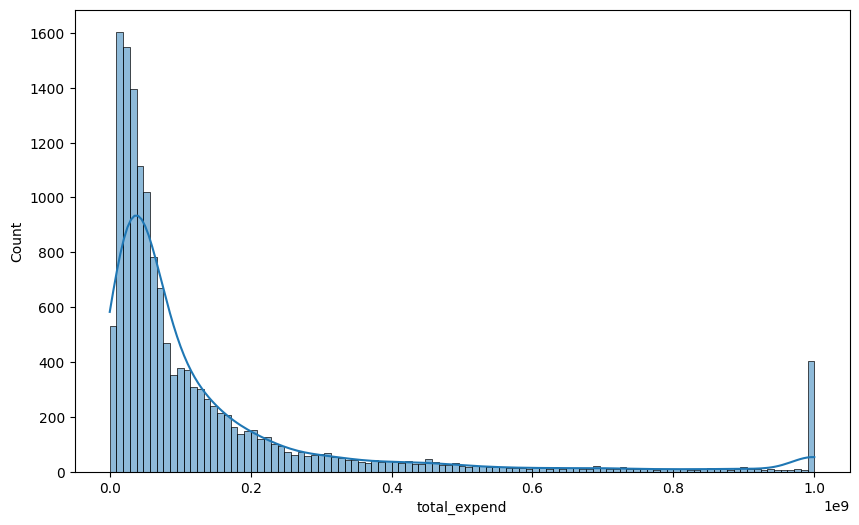

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(data=rnn_data_cleaned, x='total_expend', kde=True)
plt.show()

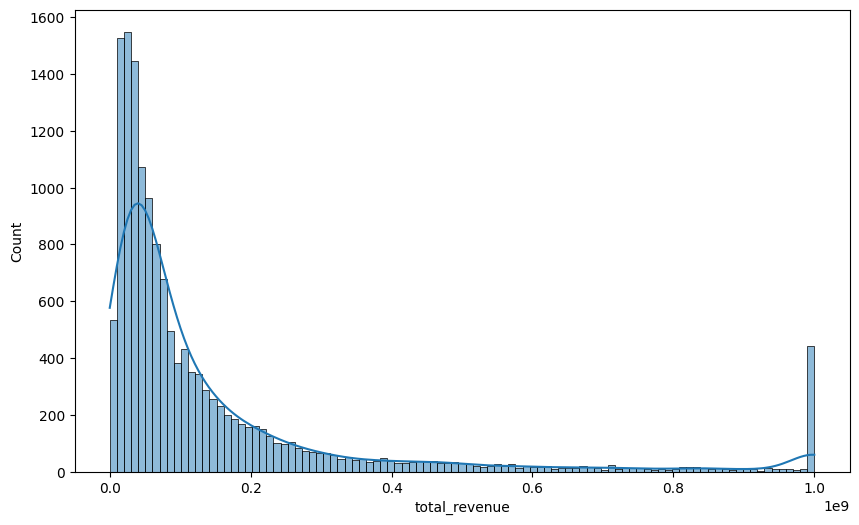

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(data=rnn_data_cleaned, x='total_revenue', kde=True)
plt.show()

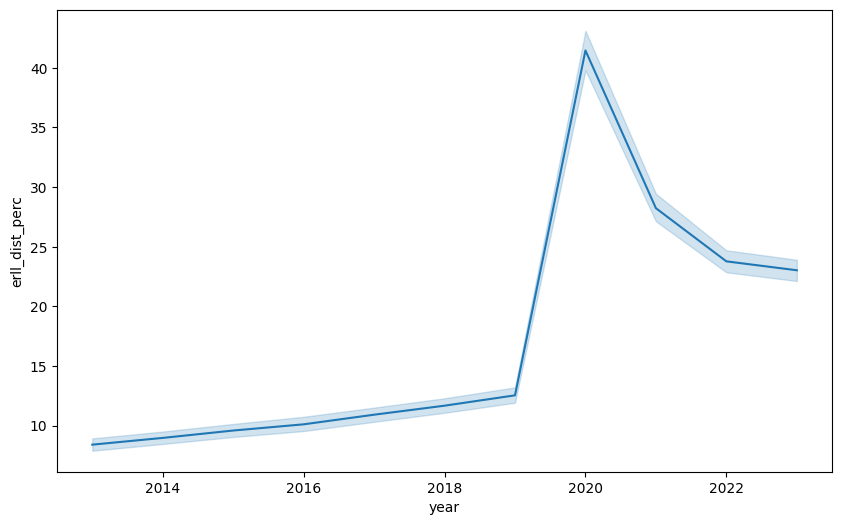

In [38]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=rnn_data_cleaned, x='year', y='erll_dist_perc')
plt.show()

In [39]:
# Build a multivariate LSTM/GRU model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Input, Concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Split the data according to the unitid
# Get unique unitids and shuffle for train/test split
unitids = rnn_data_cleaned['unitid'].unique()
np.random.seed(42)
np.random.shuffle(unitids)

train_size = int(0.8 * len(unitids))
train_unitids = unitids[:train_size]
test_unitids = unitids[train_size:]

train_data = rnn_data_cleaned[rnn_data_cleaned['unitid'].isin(train_unitids)].copy()
test_data = rnn_data_cleaned[rnn_data_cleaned['unitid'].isin(test_unitids)].copy()

# Preprocessing: encode categorical variables (using get_dummies for simplicity)
all_data = pd.concat([train_data, test_data], axis=0)
all_data = pd.get_dummies(all_data, columns=categorical_features)

train_data = all_data[all_data['unitid'].isin(train_unitids)]
test_data = all_data[all_data['unitid'].isin(test_unitids)]

# Features and target columns
feature_cols = [col for col in train_data.columns if col not in ['unitid','year','erll_dist_perc']]
target_col = 'erll_dist_perc'

# Scaling features and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# To preserve time series order, sort by unitid then year for LSTM
train_data = train_data.sort_values(['unitid', 'year'])
test_data = test_data.sort_values(['unitid', 'year'])

X_train_all = train_data[feature_cols].values
y_train_all = train_data[[target_col]].values
X_test_all = test_data[feature_cols].values
y_test_all = test_data[[target_col]].values

scaler_x.fit(X_train_all)
scaler_y.fit(y_train_all)

X_train_all = scaler_x.transform(X_train_all)
X_test_all = scaler_x.transform(X_test_all)
y_train_all = scaler_y.transform(y_train_all)
y_test_all = scaler_y.transform(y_test_all)

# Prepare LSTM input: create sequences for each unitid
# Create sequences from already scaled numpy arrays
SEQ_LEN = 5

def create_sequences_from_array(data_array, target_array, unitid_array, seq_len=3):
    """Create sequences from already scaled numpy arrays"""
    X_seqs, y_seqs = [], []
    unique_unitids = np.unique(unitid_array)
    
    for unitid in unique_unitids:
        # Get indices for this unitid
        mask = unitid_array == unitid
        unit_features = data_array[mask]
        unit_targets = target_array[mask]
        
        if len(unit_features) < seq_len:
            continue
            
        # Create sequences for this unit
        for i in range(len(unit_features) - seq_len + 1):
            X_seqs.append(unit_features[i:i+seq_len])
            y_seqs.append(unit_targets[i+seq_len-1])
    
    if len(X_seqs) == 0:
        return np.empty((0, seq_len, data_array.shape[1]), dtype=np.float32), np.empty((0, 1), dtype=np.float32)
    
    return np.array(X_seqs, dtype=np.float32), np.array(y_seqs, dtype=np.float32)

# Get unitid arrays for indexing (before scaling, to maintain alignment)
train_unitid_array = train_data['unitid'].values
test_unitid_array = test_data['unitid'].values

# Create sequences from scaled arrays
X_train, y_train = create_sequences_from_array(
    X_train_all, y_train_all, train_unitid_array, seq_len=SEQ_LEN
)
X_test, y_test = create_sequences_from_array(
    X_test_all, y_test_all, test_unitid_array, seq_len=SEQ_LEN
)

# Build the LSTM model
model = Sequential([
    LSTM(32, input_shape=(SEQ_LEN, X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)


/Users/zhonghanxie/Documents/SI/SI670/SI670_final_project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/30


/Users/zhonghanxie/Documents/SI/SI670/SI670_final_project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0484 - mae: 0.1621 - val_loss: 0.0405 - val_mae: 0.1427
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0423 - mae: 0.1504 - val_loss: 0.0405 - val_mae: 0.1417
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0418 - mae: 0.1490 - val_loss: 0.0397 - val_mae: 0.1406
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.0406 - mae: 0.1471 - val_loss: 0.0400 - val_mae: 0.1412
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0420 - mae: 0.1501 - val_loss: 0.0401 - val_mae: 0.1417
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0419 - mae: 0.1490 - val_loss: 0.0402 - val_mae: 0.1400
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.0411 - mae: 0.1477 - val_loss: 0.0406 - val_mae: 0.1375
Epoch 8/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.0427 - mae: 0.1511 - val_loss: 0.0397 - val_mae: 0.1411
Epoch 9/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step

Text(0.5, 0, 'Epoch')

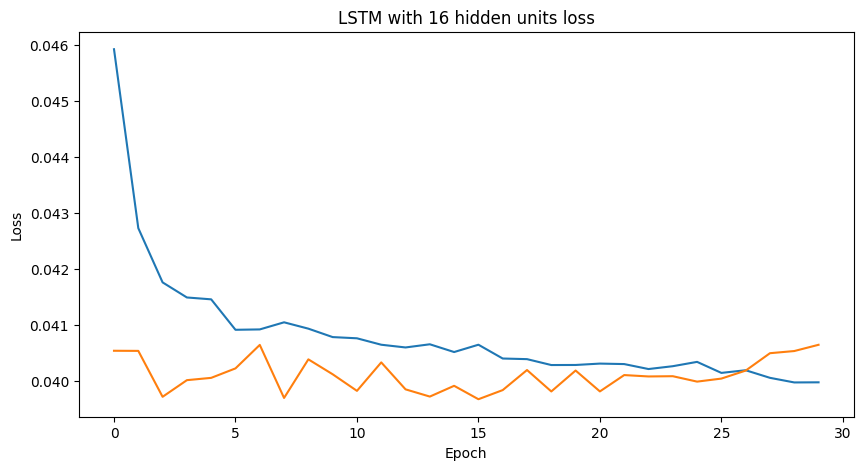

In [40]:
# Plot training & validation loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM with 16 hidden units loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [41]:

# Make predictions and invert scaling
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluation
print("Test MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
print("Test MSE:", mean_squared_error(y_test_inv, y_pred_inv))


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MAE: 14.814814567565918
Test MSE: 406.46612548828125


## Understand COVID Response

In [51]:
rnn_data_cleaned['post']=(rnn_data_cleaned['year']>=2020).astype(int)


In [78]:
model_data = rnn_data_cleaned
model_data['t'] = model_data['year']-2020

for c in ["total_revenue", "total_expend", 'eftotlt3']:
    model_data.loc[model_data[c] <= 0, c] = np.nan
model_data['lg_total_revenue'] = np.log(model_data['total_revenue'])
model_data['lg_total_expend'] = np.log(model_data['total_expend'])
model_data['lg_eftotlt3'] = np.log(model_data['eftotlt3'])
model_data = model_data.sort_values(["unitid", "year"])

model_data["lg_total_expend_l1"] = (
    model_data.groupby("unitid")["lg_total_expend"].shift(1)
)

model_data["lg_total_revenue_l1"] = (
    model_data.groupby("unitid")["lg_total_revenue"].shift(1)
)

In [80]:
from statsmodels.formula.api import ols

its_model = ols(formula='erll_dist_perc ~ t + C(post) + C(post):t + C(hbcu) + C(tribal) + C(urbanicity)+ C(instsize) + lg_eftotlt3 + lg_total_revenue_l1',
                data = model_data.dropna())
model_summary = its_model.fit(
    cov_type="cluster",
    cov_kwds={"groups": model_data.dropna()["unitid"]}).summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         erll_dist_perc   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     172.0
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          3.29e-288
Time:                        23:32:14   Log-Likelihood:                -56586.
No. Observations:               13521   AIC:                         1.132e+05
Df Residuals:                   13506   BIC:                         1.133e+05
Df Model:                          14                                         
Covariance Type:              cluster                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  92.5504     10.809      8.563      0.000      71.366     113.735
C(post)[T.1]               25.3630      0.691     36.724      0.000      24.009      26.717
C(hbcu)[T.2]                6.6111      1.044      6.333      0.000       4.565       8.657
C(tribal)[T.2]             -3.4988      3.880     -0.902      0.367     -11.103       4.105
C(urbanicity)[T.Rural]     -0.0030      0.991     -0.003      0.998      -1.946       1.940
C(urbanicity)[T.Suburb]    -0.6255      0.825     -0.758      0.448      -2.242       0.991
C(urbanicity)[T.Town]      -2.3492      0.869     -2.705      0.007      -4.052      -0.647
C(instsize)[T.2.0]         12.1528      1.726      7.039      0.000       8.769      15.537
C(instsize)[T.3.0]         13.9662      2.150      6.497      0.000       9.753      18.180
C(instsize)[T.4.0]         15.6357      2.483      6.298      0.000      10.770      20.502
C(instsize)[T.5.0]         16.0813      2.897      5.552      0.000      10.404      21.759
t                           0.9053      0.050     18.237      0.000       0.808       1.003
C(post)[T.1]:t             -6.5022      0.251    -25.931      0.000      -6.994      -6.011
lg_eftotlt3                 2.4782      0.888      2.791      0.005       0.738       4.218
lg_total_revenue_l1        -6.3444      0.731     -8.682      0.000      -7.777      -4.912
==============================================================================
Omnibus:                     3722.397   Durbin-Watson:                   0.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12807.717
Skew:                           1.372   Prob(JB):                         0.00
Kurtosis:                       6.899   Cond. No.                         659.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [76]:
model_data['t2'] = model_data['t']**2
its_second_model = ols(formula='erll_dist_perc ~ t + t2 + C(post) + C(post):t + C(post):t2 + C(hbcu) + C(tribal) + C(urbanicity)+ C(instsize) + lg_eftotlt3 + lg_total_revenue + lg_total_expend',
                data = model_data.dropna())
model_second_summary = its_second_model.fit(
    cov_type="cluster",
    cov_kwds={"groups": model_data.dropna()["unitid"]}).summary()
model_second_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         erll_dist_perc   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     154.0
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          4.96e-302
Time:                        23:29:20   Log-Likelihood:                -61773.
No. Observations:               14884   AIC:                         1.236e+05
Df Residuals:                   14866   BIC:                         1.237e+05
Df Model:                          17                                         
Covariance Type:              cluster                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  87.6262     10.647      8.230      0.000      66.759     108.493
C(post)[T.1]               28.0718      0.805     34.871      0.000      26.494      29.650
C(hbcu)[T.2]                6.6771      0.964      6.924      0.000       4.787       8.567
C(tribal)[T.2]             -2.5956      3.629     -0.715      0.474      -9.707       4.516
C(urbanicity)[T.Rural]     -0.1617      0.951     -0.170      0.865      -2.025       1.702
C(urbanicity)[T.Suburb]    -0.7104      0.803     -0.884      0.377      -2.285       0.864
C(urbanicity)[T.Town]      -2.1694      0.841     -2.580      0.010      -3.817      -0.522
C(instsize)[T.2.0]         11.6726      1.671      6.985      0.000       8.397      14.948
C(instsize)[T.3.0]         13.3692      2.089      6.398      0.000       9.274      17.464
C(instsize)[T.4.0]         14.9711      2.409      6.214      0.000      10.249      19.693
C(instsize)[T.5.0]         15.6243      2.812      5.556      0.000      10.112      21.136
t                           1.1306      0.103     10.948      0.000       0.928       1.333
C(post)[T.1]:t            -15.7950      0.725    -21.784      0.000     -17.216     -14.374
t2                          0.0308      0.011      2.731      0.006       0.009       0.053
C(post)[T.1]:t2             2.9315      0.173     16.897      0.000       2.591       3.272
lg_eftotlt3                 2.2222      0.879      2.528      0.011       0.499       3.945
lg_total_revenue           -1.2682      1.711     -0.741      0.459      -4.623       2.086
lg_total_expend            -4.6984      1.832     -2.564      0.010      -8.289      -1.107
==============================================================================
Omnibus:                     4246.016   Durbin-Watson:                   0.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16646.186
Skew:                           1.376   Prob(JB):                         0.00
Kurtosis:                       7.390   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

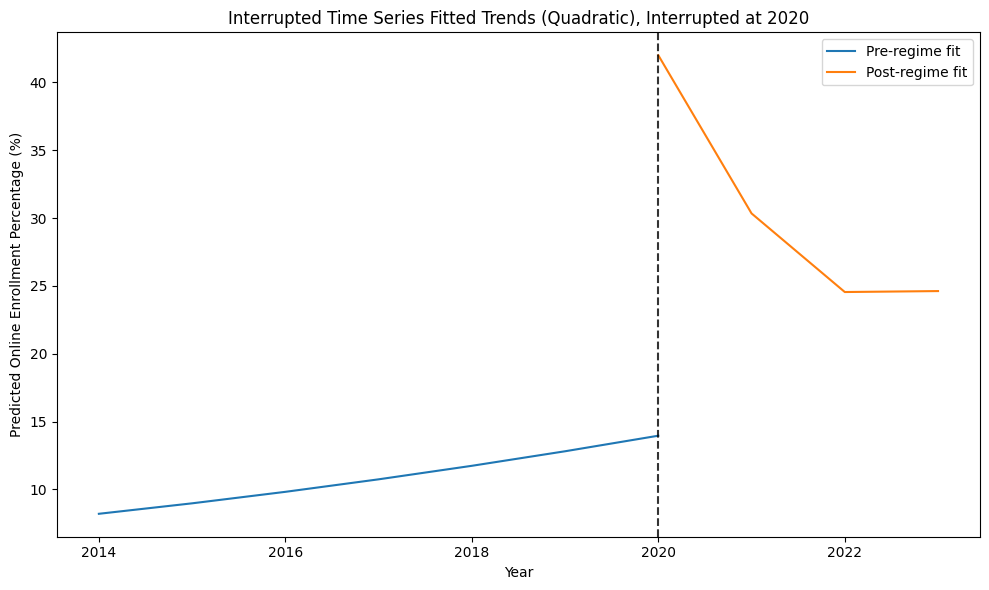

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

# --- Fit the model (as you did), but keep the fitted results object ---
df = model_data.dropna().copy()
df["t2"] = df["t"]**2

its_second_model = ols(
    formula="erll_dist_perc ~ t + t2 + C(post) + C(post):t + C(post):t2 "
            "+ C(hbcu) + C(tribal) + C(urbanicity) + C(instsize) "
            "+ lg_eftotlt3 + lg_total_revenue + lg_total_expend",
    data=df
)

res2 = its_second_model.fit(
    cov_type="cluster",
    cov_kwds={"groups": df["unitid"]}
)

# --- Build prediction grid ---
t_vals = np.arange(df["t"].min(), df["t"].max() + 1)

pred_base = pd.DataFrame({
    "t": t_vals,
    "t2": t_vals**2,

    # controls held constant (overall descriptives)
    "hbcu": df["hbcu"].mode().iloc[0],
    "tribal": df["tribal"].mode().iloc[0],
    "urbanicity": df["urbanicity"].mode().iloc[0],
    "instsize": df["instsize"].mode().iloc[0],
    "lg_eftotlt3": df["lg_eftotlt3"].mean(),
    "lg_total_revenue": df["lg_total_revenue"].mean(),
    "lg_total_expend": df["lg_total_expend"].mean()
})

pred_base["year"] = pred_base["t"] + 2020

# --- Econ ITS: force regimes ---
pred_pre = pred_base.copy()
pred_post = pred_base.copy()

pred_pre["post"] = 0
pred_post["post"] = 1

pred_pre["yhat_pre"] = res2.predict(pred_pre)
pred_post["yhat_post"] = res2.predict(pred_post)

# --- Plot interrupted fitted curves ---
cut_year = 2020
plt.figure(figsize=(10, 6))

left = pred_pre[pred_pre["year"] <= cut_year]
right = pred_post[pred_post["year"] >= cut_year]

plt.plot(left["year"], left["yhat_pre"], label="Pre-regime fit")
plt.plot(right["year"], right["yhat_post"], label="Post-regime fit")

plt.axvline(cut_year, linestyle="--", color="black", alpha=0.8)
plt.xlabel("Year")
plt.ylabel("Predicted Online Enrollment Percentage (%)")
plt.title("Interrupted Time Series Fitted Trends (Quadratic), Interrupted at 2020")
plt.legend()
plt.tight_layout()
plt.show()


In [75]:
# Heterogenous effects by different instsize
formula = (
    "erll_dist_perc ~ "
    "t + post + post:t "
    "+ post:C(instsize) + post:t:C(instsize) "
    "+ t:C(instsize) "
    "+ C(hbcu) + C(tribal) + C(urbanicity) + C(instsize) "
    "+ lg_eftotlt3 + lg_total_revenue + lg_total_expend"
)

res_size = ols(formula, data=model_data.dropna()).fit(
    cov_type="cluster",
    cov_kwds={"groups": model_data.dropna()["unitid"]}
)

res_size.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         erll_dist_perc   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     96.12
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          3.78e-292
Time:                        23:28:10   Log-Likelihood:                -61759.
No. Observations:               14884   AIC:                         1.236e+05
Df Residuals:                   14856   BIC:                         1.238e+05
Df Model:                          27                                         
Covariance Type:              cluster                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    91.4634     10.670      8.572      0.000      70.550     112.377
C(hbcu)[T.2]                  6.5795      0.963      6.833      0.000       4.692       8.467
C(tribal)[T.2]               -2.5343      3.655     -0.693      0.488      -9.697       4.628
C(urbanicity)[T.Rural]       -0.1007      0.951     -0.106      0.916      -1.966       1.764
C(urbanicity)[T.Suburb]      -0.7570      0.804     -0.942      0.346      -2.332       0.818
C(urbanicity)[T.Town]        -2.1297      0.843     -2.527      0.012      -3.782      -0.478
C(instsize)[T.2.0]            9.6759      1.886      5.129      0.000       5.979      13.373
C(instsize)[T.3.0]           10.4046      2.284      4.556      0.000       5.929      14.881
C(instsize)[T.4.0]           12.2105      2.671      4.571      0.000       6.975      17.446
C(instsize)[T.5.0]           11.7786      2.958      3.981      0.000       5.980      17.577
t                             1.0664      0.229      4.653      0.000       0.617       1.516
t:C(instsize)[T.2.0]         -0.1174      0.238     -0.494      0.621      -0.583       0.348
t:C(instsize)[T.3.0]         -0.1523      0.236     -0.646      0.518      -0.615       0.310
t:C(instsize)[T.4.0]         -0.1652      0.247     -0.669      0.504      -0.649       0.319
t:C(instsize)[T.5.0]         -0.6175      0.262     -2.359      0.018      -1.131      -0.104
post                         15.8295      2.515      6.295      0.000      10.901      20.758
post:C(instsize)[T.2.0]       5.6191      2.696      2.084      0.037       0.335      10.903
post:C(instsize)[T.3.0]      12.8313      2.893      4.435      0.000       7.161      18.502
post:C(instsize)[T.4.0]      14.8449      3.258      4.557      0.000       8.460      21.230
post:C(instsize)[T.5.0]      18.4982      3.444      5.372      0.000      11.749      25.248
post:t                       -3.8307      0.900     -4.255      0.000      -5.595      -2.066
post:t:C(instsize)[T.2.0]    -0.7676      0.962     -0.798      0.425      -2.654       1.118
post:t:C(instsize)[T.3.0]    -3.7718      1.045     -3.611      0.000      -5.819      -1.724
post:t:C(instsize)[T.4.0]    -5.4138      1.166     -4.641      0.000      -7.700      -3.128
post:t:C(instsize)[T.5.0]    -7.5551      1.272     -5.938      0.000     -10.049      -5.061
lg_eftotlt3                   2.2950      0.886      2.591      0.010       0.559       4.031
lg_total_revenue             -2.4730      1.703     -1.452      0.147      -5.811       0.865
lg_total_expend              -3.6206      1.820     -1.989      0.047      -7.188      -0.053
==============================================================================
Omnibus:                     4394.146   Durbin-Watson:                   0.811
Prob(Omnibu

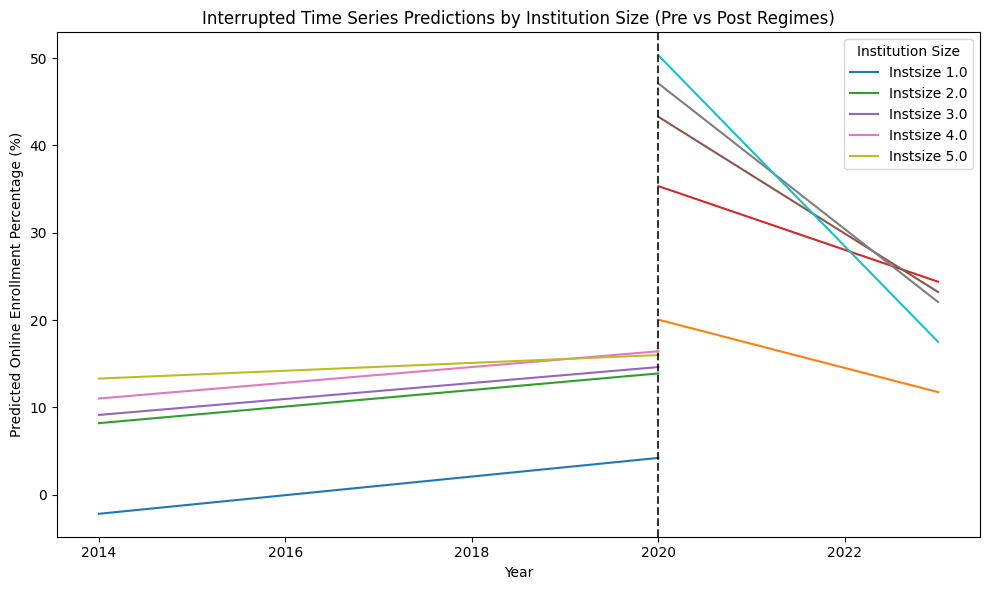

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# prediction line
df = model_data.dropna()

t_vals = np.arange(df["t"].min(), df["t"].max() + 1)
inst_sizes = sorted(df["instsize"].dropna().unique())

pred_df = pd.DataFrame([
    {
        "t": t,
        "instsize": s,

        # controls held constant
        "hbcu": df["hbcu"].mode()[0],
        "tribal": df["tribal"].mode()[0],
        "urbanicity": df["urbanicity"].mode()[0],
        "lg_eftotlt3": df["lg_eftotlt3"].mean(),
        "lg_total_revenue": df["lg_total_revenue"].mean(),
        "lg_total_expend": df["lg_total_expend"].mean()
    }
    for s in inst_sizes
    for t in t_vals
])

pred_df["year"] = pred_df["t"] + 2020

# --- Econ ITS: two regimes ---
pred_pre = pred_df.copy()
pred_post = pred_df.copy()

pred_pre["post"] = 0     # force pre-treatment regime everywhere (incl 2020)
pred_post["post"] = 1    # force post-treatment regime everywhere (incl 2020)

pred_pre["pred_erll_pre"] = res_size.predict(pred_pre)
pred_post["pred_erll_post"] = res_size.predict(pred_post)

# --- Plot: left uses pre-regime, right uses post-regime ---
plt.figure(figsize=(10, 6))
cut_year = 2020

for s in inst_sizes:
    dpre = pred_pre[pred_pre["instsize"] == s].sort_values("year")
    dpost = pred_post[pred_post["instsize"] == s].sort_values("year")

    left = dpre[dpre["year"] <= cut_year]     # includes 2020
    right = dpost[dpost["year"] >= cut_year]  # includes 2020

    plt.plot(left["year"], left["pred_erll_pre"], label=f"Instsize {s}")
    plt.plot(right["year"], right["pred_erll_post"], label="_nolegend_")

plt.axvline(cut_year, linestyle="--", color="black", alpha=0.8)
plt.xlabel("Year")
plt.ylabel("Predicted Online Enrollment Percentage (%)")
plt.title("Interrupted Time Series Predictions by Institution Size (Pre vs Post Regimes)")
plt.legend(title="Institution Size")
plt.tight_layout()
plt.show()


In [67]:
# Second order for heterogeneity

df['t2'] = df['t']**2

formula = (
    "erll_dist_perc ~ "
    # baseline time pattern
    "t + t2 "
    # COVID interruption
    "+ post + post:t + post:t2 "
    # heterogeneity by institution size
    "+ t:C(instsize) + t2:C(instsize) "
    "+ post:C(instsize) "
    "+ post:t:C(instsize) + post:t2:C(instsize) "
    # controls
    "+ C(hbcu) + C(tribal) + C(urbanicity) + C(instsize) "
    "+ eftotlt3 + lg_total_revenue + lg_total_expend"
)

model_second_instsize = ols(formula, data=df).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["unitid"]}
)

model_second_instsize.summary()



/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/3833124004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t2'] = df['t']**2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         erll_dist_perc   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     76.59
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          7.15e-302
Time:                        23:19:29   Log-Likelihood:                -61631.
No. Observations:               14884   AIC:                         1.233e+05
Df Residuals:                   14846   BIC:                         1.236e+05
Df Model:                          37                                         
Covariance Type:              cluster                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    100.9003     11.670      8.646      0.000      78.027     123.774
C(hbcu)[T.2]                   6.4989      0.961      6.763      0.000       4.615       8.382
C(tribal)[T.2]                -1.1613      3.660     -0.317      0.751      -8.335       6.012
C(urbanicity)[T.Rural]        -0.2962      0.949     -0.312      0.755      -2.157       1.565
C(urbanicity)[T.Suburb]       -0.5580      0.799     -0.699      0.485      -2.123       1.007
C(urbanicity)[T.Town]         -2.2282      0.832     -2.677      0.007      -3.860      -0.597
C(instsize)[T.2.0]            10.7900      2.287      4.717      0.000       6.307      15.273
C(instsize)[T.3.0]            12.4951      2.373      5.265      0.000       7.843      17.147
C(instsize)[T.4.0]            13.7444      2.765      4.972      0.000       8.326      19.163
C(instsize)[T.5.0]            12.9473      3.205      4.040      0.000       6.666      19.228
t                              2.2175      0.866      2.561      0.010       0.520       3.915
t:C(instsize)[T.2.0]          -1.0166      0.893     -1.139      0.255      -2.766       0.733
t:C(instsize)[T.3.0]          -1.2199      0.893     -1.366      0.172      -2.970       0.531
t:C(instsize)[T.4.0]          -1.6366      0.893     -1.832      0.067      -3.387       0.114
t:C(instsize)[T.5.0]          -1.0201      0.942     -1.083      0.279      -2.867       0.826
t2                             0.1502      0.099      1.524      0.128      -0.043       0.343
t2:C(instsize)[T.2.0]         -0.1128      0.102     -1.109      0.267      -0.312       0.087
t2:C(instsize)[T.3.0]         -0.1365      0.102     -1.339      0.180      -0.336       0.063
t2:C(instsize)[T.4.0]         -0.1891      0.104     -1.827      0.068      -0.392       0.014
t2:C(instsize)[T.5.0]         -0.0528      0.111     -0.478      0.633      -0.270       0.164
post                          14.9669      2.794      5.357      0.000       9.491      20.443
post:C(instsize)[T.2.0]        7.7969      3.008      2.592      0.010       1.901      13.693
post:C(instsize)[T.3.0]       16.9824      3.273      5.189      0.000      10.568      23.397
post:C(instsize)[T.4.0]       19.6991      3.616      5.448      0.000      12.612      26.787
post:C(instsize)[T.5.0]       25.0354      3.970      6.305      0.000      17.253      32.817
post:t                        -7.8512      2.675     -2.935      0.003     -13.095      -2.608
post:t:C(instsize)[T.2.0]     -2.3935      2.820     -0.849      0.396      -7.921       3.134
post:t:C(instsize)[T.3.0]    -10.1493      3.140     -3.233      0.001     -16.303      -3.996
post:t:C(instsize)[T.4.0]    -12.3928      3.385     -3.662      0.000     -19.026      -5.759
post:t:C(instsize)[T.5.0]    -26.0084      

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_35183/2655626270.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("instsize")


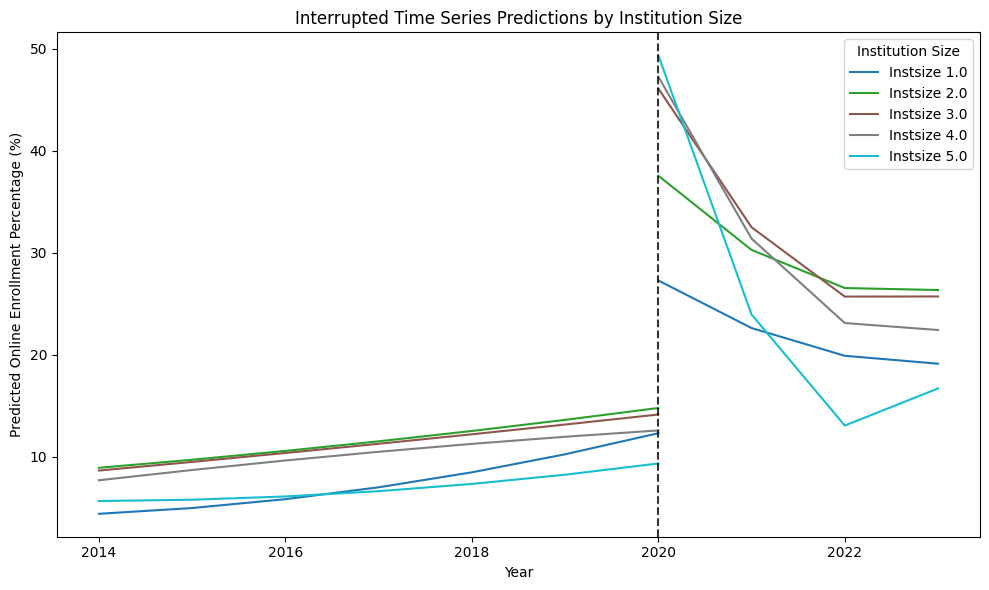

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# time range
t_vals = np.arange(df["t"].min(), df["t"].max() + 1)
inst_sizes = sorted(df["instsize"].dropna().unique())

# instsize-specific summaries
instsize_stats = (
    df.groupby("instsize")
      .agg(
          hbcu_mode=("hbcu", lambda x: x.mode().iloc[0]),
          tribal_mode=("tribal", lambda x: x.mode().iloc[0]),
          urbanicity_mode=("urbanicity", lambda x: x.mode().iloc[0]),
          eftotlt3_mean=("eftotlt3", "mean"),
          lg_total_revenue_mean=("lg_total_revenue", "mean"),
          lg_total_expend_mean=("lg_total_expend", "mean")
      )
      .reset_index()
)

# build prediction grid
pred_rows = []

for _, row in instsize_stats.iterrows():
    s = row["instsize"]

    for t in t_vals:
        pred_rows.append({
            "t": t,
            "t2": t**2,
            "instsize": s,

            # instsize-specific controls
            "hbcu": row["hbcu_mode"],
            "tribal": row["tribal_mode"],
            "urbanicity": row["urbanicity_mode"],
            "eftotlt3": row["eftotlt3_mean"],
            "lg_total_revenue": row["lg_total_revenue_mean"],
            "lg_total_expend": row["lg_total_expend_mean"]
        })

pred_df = pd.DataFrame(pred_rows)
pred_df["year"] = pred_df["t"] + 2020

# --- Econ ITS: force regimes ---
pred_pre = pred_df.copy()
pred_post = pred_df.copy()

pred_pre["post"] = 0     # pre-treatment regime everywhere
pred_post["post"] = 1    # post-treatment regime everywhere

pred_pre["pred_erll_pre"] = model_second_instsize.predict(pred_pre)
pred_post["pred_erll_post"] = model_second_instsize.predict(pred_post)

# --- Plot interrupted ITS ---
plt.figure(figsize=(10, 6))
cut_year = 2020

# assign a fixed color to each instsize
colors = plt.cm.tab10(np.linspace(0, 1, len(inst_sizes)))
color_map = dict(zip(inst_sizes, colors))

for s in inst_sizes:
    dpre = pred_pre[pred_pre["instsize"] == s].sort_values("year")
    dpost = pred_post[pred_post["instsize"] == s].sort_values("year")

    c = color_map[s]

    # pre-treatment fit (left side, includes 2020)
    left = dpre[dpre["year"] <= cut_year]
    plt.plot(
        left["year"],
        left["pred_erll_pre"],
        color=c,
        label=f"Instsize {s}"
    )

    # post-treatment fit (right side, includes 2020)
    right = dpost[dpost["year"] >= cut_year]
    plt.plot(
        right["year"],
        right["pred_erll_post"],
        color=c,
        linestyle="-",
        label="_nolegend_"
    )

# intervention marker
plt.axvline(cut_year, linestyle="--", color="black", alpha=0.8)

plt.xlabel("Year")
plt.ylabel("Predicted Online Enrollment Percentage (%)")
plt.title("Interrupted Time Series Predictions by Institution Size")
plt.legend(title="Institution Size")
plt.tight_layout()
plt.show()
